In [1]:
# grover.ipynb

import qiskit
from IPython.display import display
from qis102_utils import as_latex
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import (
    plot_distribution,
)
from qiskit_aer import AerSimulator

# Cell 1 - Check qiskit install

print(f"Qiskit SDK Version: {qiskit.__version__}")

Qiskit SDK Version: 1.1.0


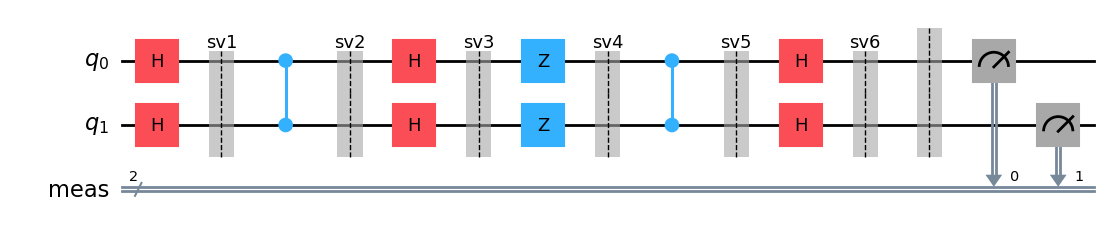

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

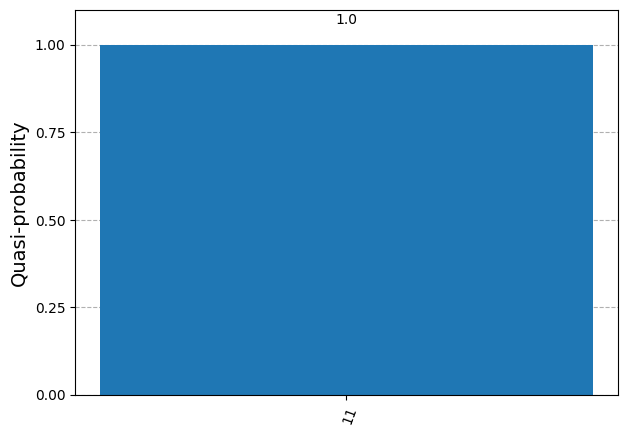

In [2]:
# Cell 2 - Grover's Algorithm (Winner is |11>)
# maximize probability of measuring the "winning" state

qc = QuantumCircuit(2)  # create a quantum circuit of two qubits
# place both qubits in a state of superposition
qc.h(0)
qc.h(1)
# measure these qubits
qc.save_statevector("sv1")
# "reflect" the superposition state over |11> perp:
# ORACLE (Uf): encodes which state is the winner
qc.cz(
    0, 1
)  # flips the phase (sign) of the target qubit if the control qubit is in the |1> state
qc.save_statevector("sv2")

# run grover's algorithm:

# put each qubit in superposition so as to measure them later (|s>)
qc.h(0)
qc.h(1)
qc.save_statevector("sv3")

# Us = 2|s><s| - 1: maps the state to UsUf|s>

# reflect over the superposition state: returns |11> state (i.e maximizes probability)
qc.z(0)  # z gate flips the phase of the |1> state leaving the |0> state unchanged
qc.z(1)
qc.save_statevector("sv4")
qc.cz(0, 1)
qc.save_statevector("sv5")

# end grover's algorithm

# measure:
qc.h(0)
qc.h(1)
qc.save_statevector("sv6")
qc.measure_all()

display(qc.draw(output="mpl"))
backend = AerSimulator()
qc_transpiled = transpile(qc, backend)
result = backend.run(qc_transpiled, shots=100_000).result()

sv1 = result.data(0)["sv1"]
sv2 = result.data(0)["sv2"]
sv3 = result.data(0)["sv3"]
sv4 = result.data(0)["sv4"]
sv5 = result.data(0)["sv5"]
sv6 = result.data(0)["sv6"]

display(as_latex(sv1, prefix=r"\mathbf{Statevector\;1}="))
display(as_latex(sv2, prefix=r"\mathbf{Statevector\;2}="))
display(as_latex(sv3, prefix=r"\mathbf{Statevector\;3}="))
display(as_latex(sv4, prefix=r"\mathbf{Statevector\;4}="))
display(as_latex(sv5, prefix=r"\mathbf{Statevector\;5}="))
display(as_latex(sv6, prefix=r"\mathbf{Statevector\;6}="))

counts = result.get_counts(qc)
display(plot_distribution(counts))

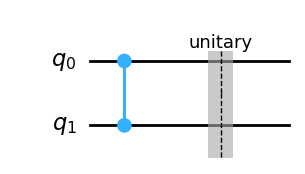

<IPython.core.display.Math object>

In [3]:
# Cell 3 - Build Grover Oracle to set |11> as winner

qc = QuantumCircuit(2)
qc.cz(0, 1)
qc.save_unitary()

display(qc.draw(output="mpl"))

backend = AerSimulator()
qc_transpiled = transpile(qc, backend)
result = backend.run(qc_transpiled).result()

op = result.get_unitary(qc, 3)
display(as_latex(op, prefix=r"Oracle="))

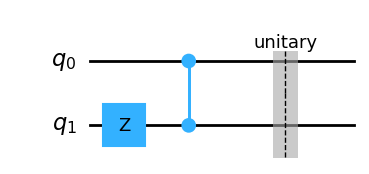

<IPython.core.display.Math object>

In [4]:
# Cell 4 - Build Grover Oracle to set |10> as winner

qc = QuantumCircuit(2)
qc.z(1)
qc.cz(0, 1)
qc.save_unitary()

display(qc.draw(output="mpl"))

backend = AerSimulator()
qc_transpiled = transpile(qc, backend)
result = backend.run(qc_transpiled).result()

op = result.get_unitary(qc, 3)
display(as_latex(op, prefix=r"Oracle="))

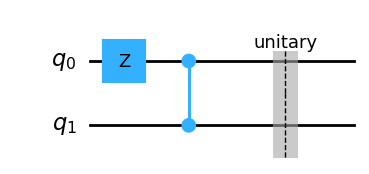

<IPython.core.display.Math object>

In [5]:
# Cell 5 - Build Grover Oracle to set |01> as winner

qc = QuantumCircuit(2)
qc.z(0)
qc.cz(0, 1)
qc.save_unitary()

display(qc.draw(output="mpl"))

backend = AerSimulator()
qc_transpiled = transpile(qc, backend)
result = backend.run(qc_transpiled).result()

op = result.get_unitary(qc, 3)
display(as_latex(op, prefix=r"Oracle="))

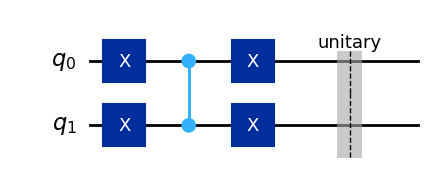

<IPython.core.display.Math object>

In [8]:
# Cell 6 - Build Grover Oracle to set |00> as winner
qc = QuantumCircuit(2)
qc.x(0)
qc.x(1)
qc.cz(0, 1)
qc.x(0)
qc.x(1)
qc.save_unitary()

display(qc.draw(output="mpl"))

backend = AerSimulator()
qc_transpiled = transpile(qc, backend)
result = backend.run(qc_transpiled).result()

op = result.get_unitary(qc, 3)
display(as_latex(op, prefix=r"Oracle="))

In [ ]:
# Cell 7: Implementing Grover's Algorithm with Linear Algebra
import numpy as np

q_0 = np.array([1, 0], dtype=complex)  # basis |0> state
q_1 = np.array([0, 1], dtype=complex)  # basis |1> state

g_I = np.array([[1, 0], [0, 1]], dtype=complex)  # identity
g_H = np.array([[1, 1], [1, -1]], dtype=complex) / np.sqrt(2)  # hadamard gate
g_H2 = np.kron(
    g_H, g_H
)  # tensor of the hadamard gate: can be applied to a two qubit register
X = np.array([[0, 1], [1, 0]], dtype=complex)  # X gate
Z = np.array([[1, 0], [0, -1]], dtype=complex)  # Z gate
c_Z = np.array(
    [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, -1]], dtype=complex
)  # control z gate
X_and_I = np.kron(X, g_I)  # applies X gate to first qubit and I to second qubit
Us = np.array(
    [[0, -1, -1, -1], [-1, 0, -1, -1], [-1, -1, 0, -1], [-1, -1, -1, 0]], dtype=complex
)


def grover(state):
    if state > 3 or state < 0:
        return None
    qr = np.kron(q_0, q_0)  # creates a two qubit quantum register
    sv1 = np.dot(g_H2, qr)  # applies the hadamard gate to each qubit

    # enter the oracle:
    if state == 0:  # |00> = [1, 0, 0, 0]
        sv2 = np.dot(X_and_I, sv1)
        sv3 = np.dot(np.kron(g_I, X), sv2)  # applies X gate to second qubit
        sv4 = np.dot(c_Z, sv3)  # applies control Z gate
        sv5 = np.dot(X_and_I, sv4)  # apply X gate to first qubit
        sv6 = np.dot(np.kron(g_I, X), sv5)  # apply X gate to second qubit
    elif state == 1:
        sv2 = np.dot(np.kron(Z, g_I), sv1)  # applies Z gate to qubit 1
        sv6 = np.dot(c_Z, sv2)  # applies control Z gate
    elif state == 2:
        sv2 = np.dot(np.kron(g_I, Z), sv1)  # applies Z gate to second qubit
        sv6 = np.dot(c_Z, sv2)  # applies control Z gate
    else:
        sv6 = np.dot(c_Z, sv1)  # applies control Z gate

    sv = np.dot(g_H2, sv6)
    """sv7 = np.dot(np.kron(Z, Z), sv)
    sv8 = np.dot(Us, sv7)
    sv9 = np.dot(g_H2, sv8)"""
    sv9_array = np.array(sv)
    print(sv9_array)


grover(0)
grover(1)
grover(2)
grover(3)


In [ ]:
# Cell-8 Grover's Algorithm with n qubits
# step 1: apply hadamard gate to every qubit
# step 2: apply grover's operation t times
    # G = H(xn) Zor H(xn) Zr = H(xn)|u><u| - I
    # determine t based on:

def grover(n, state):
    qc = QuantumCircuit(n)
    for i in range(n):
        qc.h(i)
    
    
    # n = number of qubits